In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from EngineerFeature import FeatureEngineer

In [255]:
# Veri setini yükle
from sklearn.discriminant_analysis import StandardScaler
scaler = StandardScaler()

from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

data = pd.read_csv('../final_data.csv')
#data = data.drop(columns=['artist'])
# Özellikler ve hedef değişkeni ayır
X = data.drop("popularity", axis=1)
y = data["popularity"]

# Eğitim ve test setlerine ayır (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Feature Engineering uygula
fe = FeatureEngineer()
X_train = fe.fit_transform(X_train, y_train)
X_test = fe.transform(X_test)
#X_train.drop('artist_song_count', axis=1, inplace=True)
#X_test.drop('artist_song_count', axis=1, inplace=True)
print(X_train.columns)
# Scaling uygula
cols = X_train.columns#.difference(['artist_avg_popularity'])#, 'artist_song_count'])
X_train = pd.DataFrame(
    scaler.fit_transform(X_train[cols]),
    columns=cols,#X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test[cols]),
    columns=cols,#X_test.columns,
    index=X_test.index
)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Özellik sayısı: {X_train.shape[1]}")

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_count', 'subgenre_album rock',
       'subgenre_big room', 'subgenre_classic rock', 'subgenre_dance pop',
       'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'album_age_log', 'artist_song_count',
       'artist_avg_popularity', 'artist_high_pop_ratio',
       'artist_song_count_bin'],
      dtype='object')
Eğitim seti boy

In [256]:
# Temel Lasso Regresyon Modeli (alpha=1.0)
lasso_base = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso_base.fit(X_train, y_train)

# Tahminler
y_train_pred = lasso_base.predict(X_train)
y_test_pred = lasso_base.predict(X_test)

# Metrikleri hesapla
print(f"Eğitim - MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"Eğitim - RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Eğitim - R²: {r2_score(y_train, y_train_pred):.4f}")
print()
print(f"Test - MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Test - RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"Test - R²: {r2_score(y_test, y_test_pred):.4f}")

Eğitim - MAE: 10.3065
Eğitim - RMSE: 15.3222
Eğitim - R²: 0.5831

Test - MAE: 15.9550
Test - RMSE: 20.7161
Test - R²: 0.2287


In [257]:
# Hiperparametre Optimizasyonu (GridSearchCV)
param_grid = {
    "alpha": np.logspace(-3, 3, 20)  # 0.001'den 1000'e kadar
}

lasso = Lasso(random_state=24, max_iter=10000)

grid_search = GridSearchCV(
    lasso,
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV başlıyor...")
grid_search.fit(X_train, y_train)

print("HİPERPARAMETRE OPTİMİZASYONU SONUÇLARI")
print(f"En iyi alpha değeri: {grid_search.best_params_['alpha']:.4f}")
print(f"En iyi CV MAE: {-grid_search.best_score_:.4f}")

GridSearchCV başlıyor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
HİPERPARAMETRE OPTİMİZASYONU SONUÇLARI
En iyi alpha değeri: 0.1624
En iyi CV MAE: 10.1312


In [258]:
# En iyi modeli test seti üzerinde değerlendir
best_lasso = grid_search.best_estimator_
y_test_pred_best = best_lasso.predict(X_test)
y_train_pred_best = best_lasso.predict(X_train)

print("EN İYİ LASSO MODEL PERFORMANSI")
print(f"Eğitim - MAE: {mean_absolute_error(y_train, y_train_pred_best):.4f}")
print(f"Eğitim - RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_best)):.4f}")
print(f"Eğitim - R²: {r2_score(y_train, y_train_pred_best):.4f}")
print()
print(f"Test - MAE: {mean_absolute_error(y_test, y_test_pred_best):.4f}")
print(f"Test - RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_best)):.4f}")
print(f"Test - R²: {r2_score(y_test, y_test_pred_best):.4f}")

# En iyi modeldeki sıfır olmayan özellik sayısı
nonzero_count = np.sum(best_lasso.coef_ != 0)
print(f"\nSeçilen özellik sayısı: {nonzero_count} / {len(best_lasso.coef_)}")

EN İYİ LASSO MODEL PERFORMANSI
Eğitim - MAE: 10.1144
Eğitim - RMSE: 15.1284
Eğitim - R²: 0.5936

Test - MAE: 15.6984
Test - RMSE: 20.4732
Test - R²: 0.2467

Seçilen özellik sayısı: 25 / 41


In [259]:
# GridSearchCV sonuçlarını detaylı analiz
results_df = pd.DataFrame(grid_search.cv_results_)
results_df["alpha"] = results_df["param_alpha"].astype(float)
results_df["mean_MAE"] = -results_df["mean_test_score"]
results_df["std_MAE"] = results_df["std_test_score"]

results_sorted = results_df.sort_values("rank_test_score")
print("\nTüm alpha değerleri için sonuçlar (en iyi 10):")
print(results_sorted[["alpha", "mean_MAE", "std_MAE", "rank_test_score"]].head(10).to_string(index=False))


Tüm alpha değerleri için sonuçlar (en iyi 10):
   alpha  mean_MAE  std_MAE  rank_test_score
0.162378 10.131167 0.159223                1
0.335982 10.138609 0.148198                2
0.078476 10.159168 0.162889                3
0.037927 10.181795 0.164805                4
0.018330 10.196764 0.166471                5
0.008859 10.205637 0.167083                6
0.004281 10.210490 0.167221                7
0.695193 10.212172 0.138283                8
0.002069 10.213033 0.167272                9
0.001000 10.214312 0.167311               10


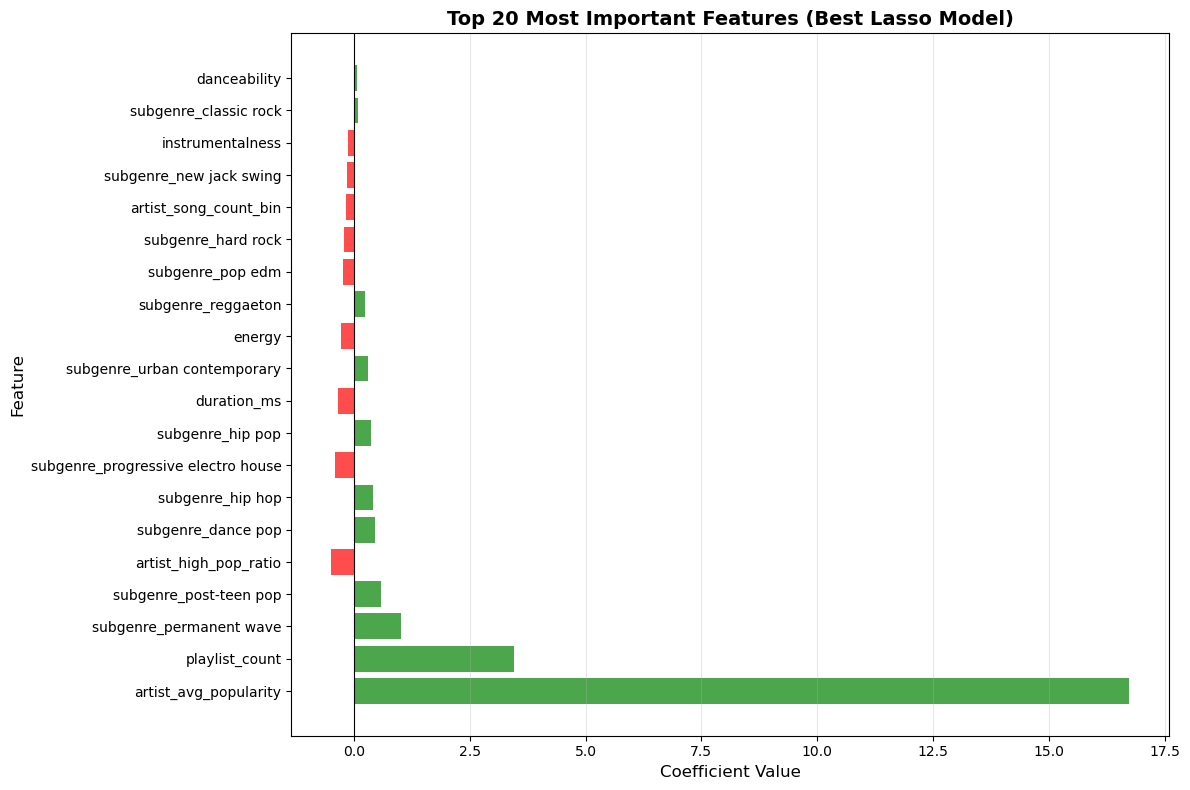

In [260]:
# Görselleştirme 4: En iyi modelin feature importance
best_feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": best_lasso.coef_
})

# Sıfır olmayan katsayıları al ve mutlak değere göre sırala
top_features = best_feature_importance[best_feature_importance["coefficient"] != 0].copy()
top_features = top_features.sort_values(by="coefficient", key=abs, ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = ["green" if x > 0 else "red" for x in top_features["coefficient"]]
plt.barh(range(len(top_features)), top_features["coefficient"], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 20 Most Important Features (Best Lasso Model)", fontsize=14, fontweight="bold")
plt.axvline(x=0, color="black", linestyle="-", linewidth=0.8)
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

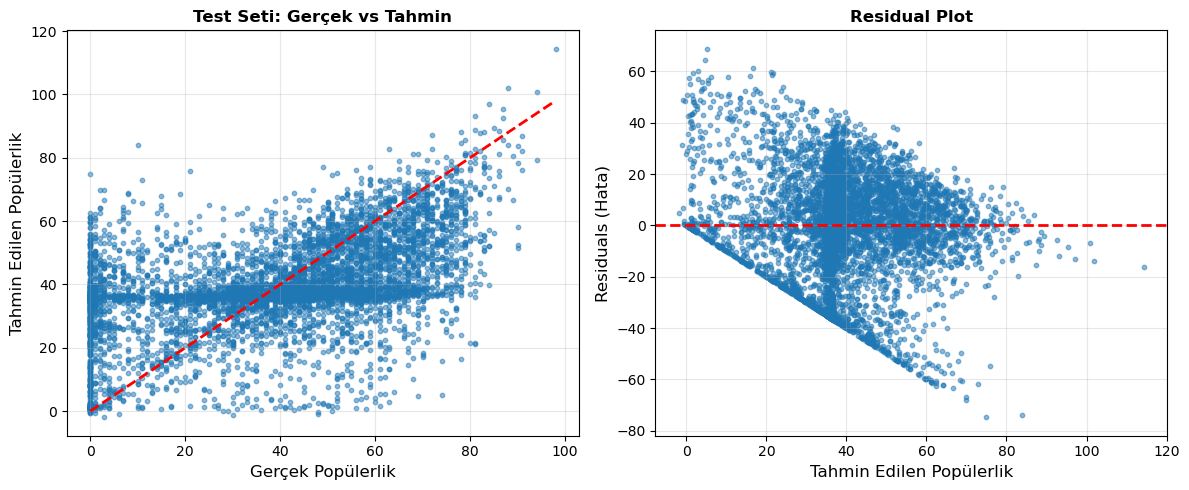

In [261]:
# Görselleştirme 5: Gerçek vs Tahmin edilen değerler
plt.figure(figsize=(12, 5))

# Test seti
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_best, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Gerçek Popülerlik", fontsize=12)
plt.ylabel("Tahmin Edilen Popülerlik", fontsize=12)
plt.title("Test Seti: Gerçek vs Tahmin", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred_best
plt.scatter(y_test_pred_best, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Tahmin Edilen Popülerlik", fontsize=12)
plt.ylabel("Residuals (Hata)", fontsize=12)
plt.title("Residual Plot", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()